In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from PIL import Image
from torchvision.transforms import ToTensor, Normalize
from time import time
import cv2

from implicit_kan.ChebyKANLayer import ChebyKANLayer
from implicit_kan.KANLayer import FastKANLayer, KANLinear
from implicit_kan.utils import get_grid
from implicit_kan.modules import GaussianFourierFeatureTransform

h = 128
w = 128

num_steps = 2500

In [2]:
img = ToTensor()(Image.open('./inputs/eye.jpeg').resize((h, w)))[None] * 2 - 1.

In [3]:
img.shape

torch.Size([1, 3, 128, 128])

In [4]:
grid = get_grid(img.shape[2], img.shape[3], b=1)

In [5]:
class ImplicitKAN(nn.Module):
    def __init__(self, pos_enc='gff'):
        super(ImplicitKAN, self).__init__()
        self.pos_enc = pos_enc
        assert pos_enc in ['gff', 'kan']
        if pos_enc == 'gff':
            self.pe = GaussianFourierFeatureTransform(mapping_dim=64)
        elif pos_enc == 'kan':
            self.pe =  FastKANLayer(2, 128)
        self.kan1 = FastKANLayer(128, 32)
        self.kan2 = FastKANLayer(32, 16)
        self.kan3 = FastKANLayer(16, 3)

    def forward(self, x):
        if self.pos_enc == 'kan':
            x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
            x = self.pe(x)
        elif self.pos_enc == 'gff':
            x = self.pe(x)
            x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
        x = self.kan1(x)
        x = self.kan2(x)
        x = self.kan3(x)
        return x.reshape(1, 3, h, w)

In [6]:
class ImplicitEKAN(nn.Module):
    def __init__(self, pos_enc='gff'):
        super(ImplicitEKAN, self).__init__()
        self.pos_enc = pos_enc
        assert pos_enc in ['gff', 'kan']
        if pos_enc == 'gff':
            self.pe = GaussianFourierFeatureTransform(mapping_dim=64)
        elif pos_enc == 'kan':
            self.pe =  KANLinear(2, 128)
        self.kan1 = KANLinear(128, 32)
        self.kan2 = KANLinear(32, 16)
        self.kan3 = KANLinear(16, 3)

    def forward(self, x):
        if self.pos_enc == 'kan':
            x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
            x = self.pe(x)
        elif self.pos_enc == 'gff':
            x = self.pe(x)
            x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
        x = self.kan1(x)
        x = self.kan2(x)
        x = self.kan3(x)
        return x.reshape(1, 3, h, w)
    
    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in [self.kan1, self.kan2, self.kan3]
        )

In [7]:
class ImplicitMLP(nn.Module):
    def __init__(self):
        super(ImplicitMLP, self).__init__()
        self.gff = GaussianFourierFeatureTransform(mapping_dim=128)
        self.linear1 = nn.Linear(2 * 128, 128)
        self.ln1 = nn.LayerNorm(128) # To avoid gradient vanishing caused by tanh
        self.linear2 = nn.Linear(128, 64)
        self.ln2 = nn.LayerNorm(64)
        self.linear3 = nn.Linear(64, 32)
        self.ln3 = nn.LayerNorm(32)
        self.linear4 = nn.Linear(32, 3)
        # self.ln4 = nn.LayerNorm(8)
        # self.linear5 = nn.Linear(8, 3)
    
    def forward(self, x):
        x = self.gff(x)
        x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
        x = self.linear1(x)
        x = F.tanh(x)
        x = self.ln1(x)
        x = self.linear2(x)
        x = F.tanh(x)
        x = self.ln2(x)
        x = self.linear3(x)
        x = F.tanh(x)
        x = self.ln3(x)
        x = self.linear4(x)
        # x = F.tanh(x)
        # x = self.ln4(x)
        # x = self.linear5(x)
        return x.reshape(1, 3, h, w)


In [8]:
kan_model = ImplicitEKAN(pos_enc='gff')
total_params = sum(p.numel() for p in kan_model.parameters() if p.requires_grad)
print(f"Total trainable parameters in efficient kan with gff: {total_params}")

kan_model_gff = ImplicitKAN(pos_enc='gff')
total_params = sum(p.numel() for p in kan_model_gff.parameters() if p.requires_grad)
print(f"Total trainable parameters in fast kan with gff: {total_params}")

mlp = ImplicitMLP()
total_params_mlp = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print(f"Total trainable parameters in MLP with gff: {total_params_mlp}")

optim_kan = optim.AdamW(kan_model.parameters(), lr=1e-2, weight_decay=1e-4)
optim_kan_gff = optim.AdamW(kan_model_gff.parameters(), lr=1e-2, weight_decay=1e-4)
optim_mlp = optim.AdamW(mlp.parameters(), lr=1e-2, weight_decay=1e-4)

Total trainable parameters in efficient kan with gff: 46560
Total trainable parameters in fast kan with gff: 42307
Total trainable parameters in MLP with gff: 43779


In [9]:
kan_loss = []
ekan_gff_imgs = []
start = time()
for step_idx in range(num_steps):
    optim_kan.zero_grad()
    out = kan_model(grid)
    loss = ((F.tanh(out) - img) ** 2).mean()# + kan_model.regularization_loss()
    loss.backward()
    optim_kan.step()
    kan_loss.append(((F.tanh(out) - img) ** 2).mean())
    ekan_gff_imgs.append(out)
kan_loss = [l.item() for l in kan_loss]
ekan_gff_imgs = [im.cpu().data.numpy() for im in ekan_gff_imgs]
print(f"trained in {time() - start} to {kan_loss[-1]}")

trained in 2791.9700870513916 to 0.0037611015141010284


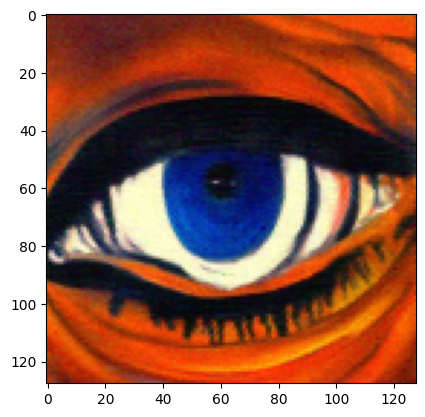

In [10]:
plt.imshow((F.tanh(out).cpu()[0].permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [11]:
kan_gff_imgs = []
kan_gff_loss = []
start = time()
for step_idx in range(num_steps):
    optim_kan_gff.zero_grad()
    out = kan_model_gff(grid)
    loss = ((F.tanh(out) - img) ** 2).mean()
    loss.backward()
    optim_kan_gff.step()
    kan_gff_loss.append(loss)
    kan_gff_imgs.append(out)

kan_gff_loss = [l.item() for l in kan_gff_loss]
kan_gff_imgs = [im.cpu().data.numpy() for im in kan_gff_imgs]

print(f"trained in {time() - start} to {loss.item()}")

trained in 1096.169188261032 to 0.010420325212180614


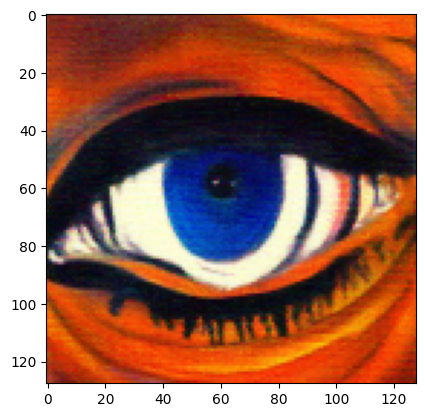

In [12]:
plt.imshow((F.tanh(out).cpu()[0].permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [13]:
mlp_imgs = []
mlp_loss = []
start = time()
for step_idx in range(num_steps):
    mlp.zero_grad()
    out = mlp(grid)
    loss = ((F.tanh(out) - img) ** 2).mean()
    loss.backward()
    optim_mlp.step()
    mlp_loss.append(loss)
    mlp_imgs.append(out)

mlp_loss = [l.item() for l in mlp_loss]
mlp_imgs = [im.cpu().data.numpy() for im in mlp_imgs]

print(f"trained in {time() - start} to {loss.item()}")

trained in 76.38310599327087 to 0.0005243876366876066


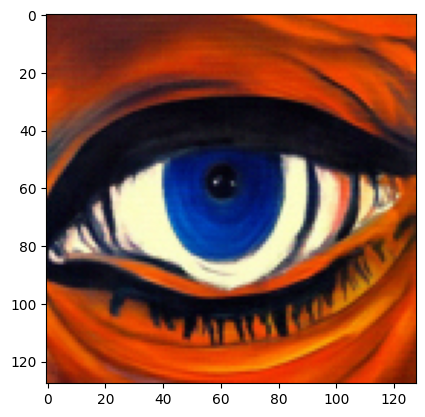

In [14]:
plt.imshow((F.tanh(out).cpu()[0].permute(1, 2, 0).data.numpy() + 1.) / 2.)

[]

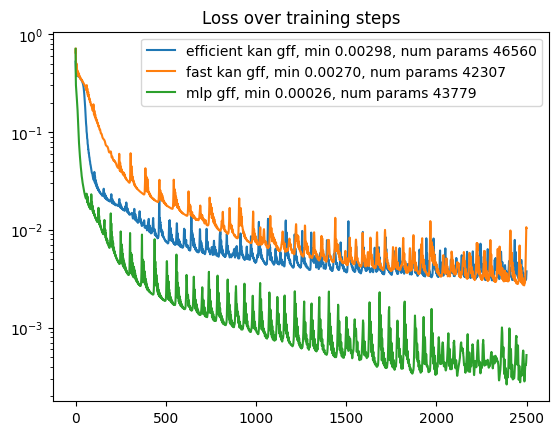

In [18]:
plt.plot(kan_loss, label=f'efficient kan gff, min {min(kan_loss):.5f}, num params {sum(p.numel() for p in kan_model.parameters() if p.requires_grad)}')

plt.plot(kan_gff_loss, label=f'fast kan gff, min {min(kan_gff_loss):.5f}, num params {sum(p.numel() for p in kan_model_gff.parameters() if p.requires_grad)}')

plt.plot(mlp_loss, label=f'mlp gff, min {min(mlp_loss):.5f}, num params {sum(p.numel() for p in mlp.parameters() if p.requires_grad)}')
plt.legend()
plt.title("Loss over training steps")
plt.semilogy()

In [19]:
out = cv2.VideoWriter('converge.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 20, (w * 3, h))
for i in range(num_steps):
    frame = (np.tanh(rearrange(np.concatenate([ekan_gff_imgs[i][0], kan_gff_imgs[i][0], mlp_imgs[i][0]], axis=2), "c h w -> h w c")) + 1) / 2. * 255
    out.write(frame.astype(np.uint8)[:, :, ::-1])
out.release()

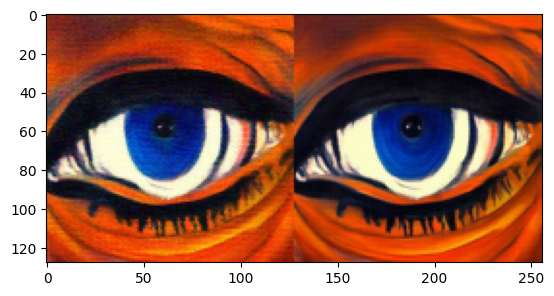

In [17]:
plt.imshow((np.tanh(rearrange(np.concatenate([kan_gff_imgs[-1][0], mlp_imgs[-1][0]], axis=2), "c h w -> h w c")) + 1) / 2.)